# Imports

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

import os
import pathlib
from PIL import Image
import glob

In [2]:
data_dir = "D:\\Formation\\IASchool\\DeepLearning\\car_detection\\image\\data"

# Data preparation

In [3]:
data_dir = pathlib.Path(data_dir)

In [4]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(64, 64),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="training",
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 17760 files belonging to 2 classes.
Using 14208 files for training.


In [5]:
validation_df = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    labels="inferred",
    label_mode='int',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(64, 64),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation",
    interpolation='bilinear',
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 17760 files belonging to 2 classes.
Using 3552 files for validation.


In [6]:
val_batches = tf.data.experimental.cardinality(validation_df)
test_dataset = validation_df.take(val_batches // 5)
validation_dataset = validation_df.skip(val_batches // 5)

In [7]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['non-vehicles' 'vehicles']


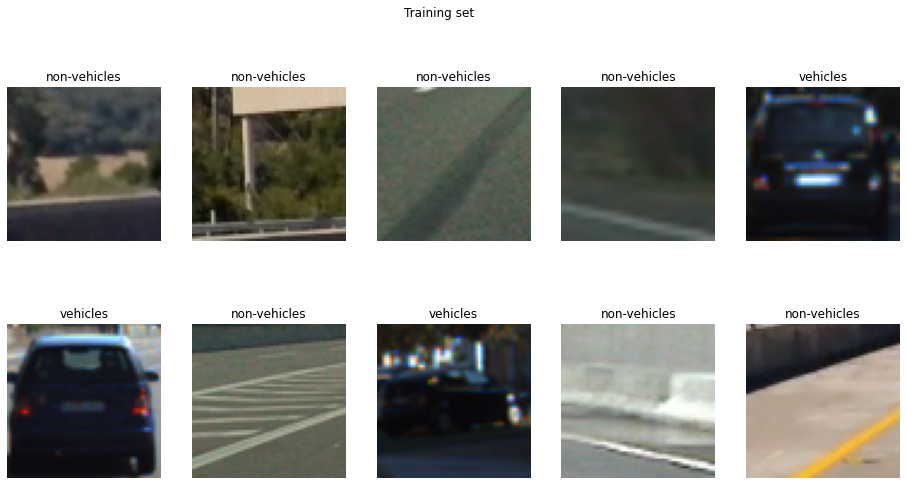

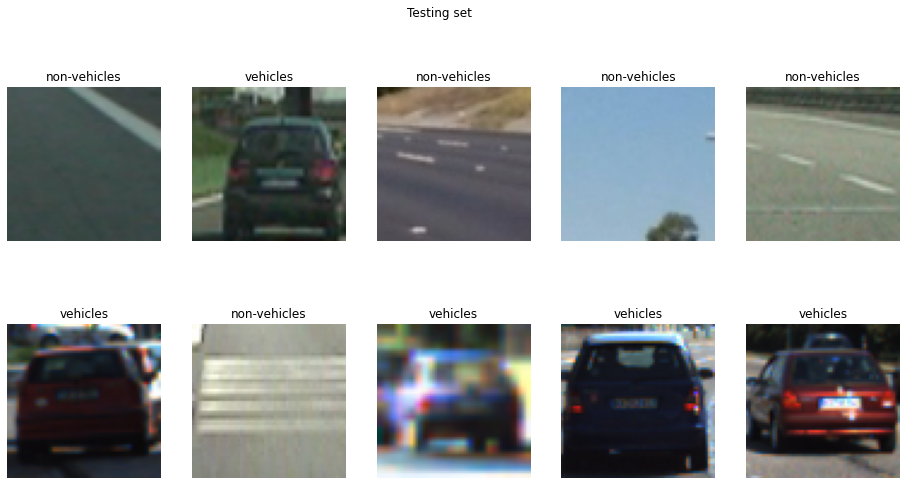

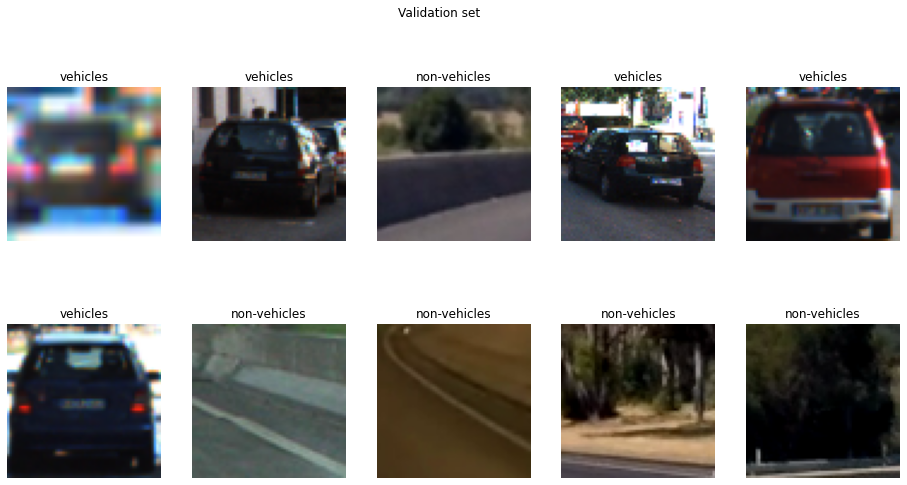

In [8]:
import matplotlib.pyplot as plt

for images, labels in train_dataset.take(1):
  plt.figure(figsize=(16, 8))
  plt.suptitle("Training set")
  for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
  plt.show()

for images, labels in test_dataset.take(1):
  plt.figure(figsize=(16, 8))
  plt.suptitle("Testing set")
  for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
  plt.show()

for images, labels in validation_dataset.take(1):
  plt.figure(figsize=(16, 8))
  plt.suptitle("Validation set")
  for i in range(10):
    ax = plt.subplot(2, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")
  plt.show()

In [9]:
print('Number of training batches: %d' % tf.data.experimental.cardinality(train_dataset))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of training batches: 444
Number of validation batches: 89
Number of test batches: 22


In [10]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Transfer learning

In [11]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions

model = ResNet50(weights='imagenet')

In [12]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [13]:
# Extracting informations

model_config = model.get_config()

# Changing the configuration

input_layer_name = model_config['layers'][0]['name']
model_config['layers'][0] = {
                      'name': 'new_input',
                      'class_name': 'InputLayer',
                      'config': {
                          'batch_input_shape': (None, 64, 64, 3),
                          'dtype': 'float32',
                          'sparse': False,
                          'name': 'new_input'
                      },
                      'inbound_nodes': []
                  }
model_config['layers'][1]['inbound_nodes'] = [[['new_input', 0, 0, {}]]]
model_config['input_layers'] = [['new_input', 0, 0]]

# Implement new model

new_model = model.__class__.from_config(model_config, custom_objects={})  # change custom objects if necessary

In [14]:
new_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 new_input (InputLayer)         [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 70, 70, 3)    0           ['new_input[0][0]']              
                                                                                                  
 conv1_conv (Conv2D)            (None, 32, 32, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 32, 32, 64)   256         ['conv1_conv[0][0]']             
                                                                                           

In [15]:
img_path = 'image\\data\\non-vehicles\\extra2.png'
img = image.load_img(img_path, target_size=(64, 64))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = new_model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])

Predicted: [('n03124170', 'cowboy_hat', 0.13504888), ('n02877765', 'bottlecap', 0.086137064), ('n02699494', 'altar', 0.052066952)]


Le modèle importé n'est pas adapté à nos données

In [16]:
model = new_model

In [17]:
model.trainable = True

In [18]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model:  177


In [19]:
# Les layers de type batch normalization doivent rester non entraînable, donc il faut remettre cette variable à False

count = fine_tune_at
for layer in model.layers[fine_tune_at:]:
    count+=1
    if layer.__class__.__name__ == "BatchNormalization":

        layer.trainable = False

        print("layer n°", count)
        print(layer.__class__.__name__)

layer n° 101
BatchNormalization
layer n° 105
BatchNormalization
layer n° 108
BatchNormalization
layer n° 111
BatchNormalization
layer n° 115
BatchNormalization
layer n° 118
BatchNormalization
layer n° 121
BatchNormalization
layer n° 125
BatchNormalization
layer n° 128
BatchNormalization
layer n° 131
BatchNormalization
layer n° 135
BatchNormalization
layer n° 138
BatchNormalization
layer n° 141
BatchNormalization
layer n° 145
BatchNormalization
layer n° 148
BatchNormalization
layer n° 152
BatchNormalization
layer n° 153
BatchNormalization
layer n° 157
BatchNormalization
layer n° 160
BatchNormalization
layer n° 163
BatchNormalization
layer n° 167
BatchNormalization
layer n° 170
BatchNormalization
layer n° 173
BatchNormalization


In [20]:
for layer in model.layers[98:102]:
  print(layer)
  print(layer.name)
  print(layer.trainable)

conv4_block2_2_relu
False
conv4_block2_3_conv
False
conv4_block2_3_bn
False
conv4_block2_add
True


In [21]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = model(image_batch)
print(feature_batch.shape)

(32, 1000)


In [22]:
# Ici on a besoin d'une classification binaire, donc pas besoin d'avoir des prédictions pour chaque classe.
# On utilise une dense layer pour prédire entre deux classes (0 ou 1)

prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch)
print(prediction_batch.shape)

(32, 1)


In [23]:
inputs = tf.keras.Input(shape=(64, 64, 3))
x = preprocess_input(inputs)
x = model(x, training=False)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [24]:
base_learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [25]:
loss0, accuracy0 = model.evaluate(validation_dataset)
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

89/89 [==============================] - 27s 282ms/step - loss: 0.6951 - accuracy: 0.4975
initial loss: 0.70
initial accuracy: 0.50


Pas terrible pour le moment.

On va entraîner les dernières layers retenues

In [26]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=3,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

In [27]:
initial_epochs = 10

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset,
                    callbacks=[early_stop])

Epoch 1/10
444/444 [==============================] - 564s 1s/step - loss: 0.6934 - accuracy: 0.5085 - val_loss: 0.6930 - val_accuracy: 0.4905
Epoch 2/10
112/444 [======>.......................] - ETA: 6:19 - loss: 0.6934 - accuracy: 0.5056

KeyboardInterrupt: 

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()